In [1]:
import io
import os
import pickle
import random as rn
import warnings
from datetime import datetime
from importlib import reload
from multiprocessing import cpu_count

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
from IPython.display import display
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, ndcg_score, \
        label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

import data
import models
import preprocessing

seed = 42
sns.set()

def reset_seed():
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    np.random.seed(seed)
    rn.seed(seed)
    tf.random.set_seed(seed)

## Choose notebook version

In [2]:
version = "tokenized_cased"
# version = "tokenized_no_sw_no_punct"
# version = "tokenized_lemmatized_no_sw_no_punct"

## Extracting the data

In [3]:
# data.extract_data(extraction_dir="train",
#                   data_dir="data",
#                   data_zip_name="reuters-training-corpus.zip")

train_df = pd.read_pickle("train/data.pkl")

# train_df = data.get_docs_labels("train/REUTERS_CORPUS_2")
# train_df.to_pickle("train/data.pkl")

train_docs = train_df["doc"].values
n_train = train_docs.shape[0]
train_labels = np.array(train_df["labels"].tolist())
n_labels = len(data.CODEMAP)

print(train_docs.shape)
print(train_labels.shape)
print(train_docs[2])
print(train_labels[2])

(299773,)
(299773, 126)
Toronto stocks end higher after volatile session. CHANGE				    CHANGE TSE	  5900.37    +50.15   HI 5900.37	    LO  5840.29 DJI	  6611.05    +27.57   GOLD (LONDON)   US$350.00 +1.90 FTSE100    4248.10    -64.80   GOLD (NY-COMEX) US$354.80 +0.70 NIKKEI    17869.59   -133.81   LME CASH NICKEL US$7659   +99.0 CANDLR	1.3883		 LME CASH ALUM   US$1602.0  -4.0 CAN 30-YR   107.41     -0.15   BRENT CRUDE     US$19.09  -0.27 --------------------MARKET COMMENT---------------------------- * Toronto stocks ended higher on Tuesday, buoyed by strength in golds and banking * Computer problems due to heavy trading in Bre-X Minerals hampered session * 84 million shares traded Toronto's key stock index ended higher on Tuesday as the saga of Bre-X Minerals Ltd and its Indonesian gold find continued to dominate Canada's biggest stock market. The TSE 300 Index climbed 50.15 points to close at 5900.37 in heavy turnover of 84.07 million shares worth C$1.4 billion. But the overall marke

In [4]:
test_df = pd.read_pickle("test/data.pkl")

# test_df = data.get_docs_labels("test/text-test-corpus-STRIPPED")
# test_df.to_pickle("test/data.pkl")

test_docs = test_df["doc"].values

print(test_docs.shape)
print(test_docs[2])

(33142,)
OFFICIAL JOURNAL CONTENTS - OJ L 94 OF APRIL 9, 1997. * (Note - contents are displayed in reverse order to that in the printed Journal) * COMMISSION DECISION of 14 March 1997 amending the list of declining industrial areas concerned by Objective 2 as defined by Council Regulation (EEC) No 2052/88 (97/237/EC) COMMISSION DECISION of 13 March 1997 authorizing the grant by Finland of national aid in the reindeer sector (Only the Finnish and Swedish texts are authentic) (97/236/EC) COMMISSION DECISION of 6 March 1997 approving a modification to the single programming document for Community structural measures for improving the processing and marketing conditions for agricultural products in the Grand Duchy of Luxembourg, in respect of Objective 5 (a), covering the period between 1994 and 1999 (Only the French text is authentic) (97/235/EC) COMMISSION DECISION of 3 March 1997 amending Decision 96/233/EC establishing the list of approved fish farms in Denmark (Text with EEA relevance

## Preprocessing the documents

In [5]:
path_to_preprocessed_train_docs = f"train/preprocessed_docs_{version}.pkl"

try:
    with open(path_to_preprocessed_train_docs, "rb") as f:
        preprocessed_train_docs = pickle.load(f)
except:
    preprocessed_train_docs = preprocessing.preprocess_corpus(train_docs)
    with open(path_to_preprocessed_train_docs, "wb") as f:
        pickle.dump(preprocessed_train_docs, f)

print(preprocessed_train_docs[2])

Toronto stocks end higher after volatile session . CHANGE CHANGE TSE 5900.37 +50.15 HI 5900.37 LO 5840.29 DJI 6611.05 +27.57 GOLD ( LONDON ) US$ 350.00 +1.90 FTSE100 4248.10 -64.80 GOLD ( NY - COMEX ) US$ 354.80 +0.70 NIKKEI 17869.59 -133.81 LME CASH NICKEL US$ 7659 +99.0 CANDLR 1.3883 LME CASH ALUM US$ 1602.0 -4.0 CAN 30-YR 107.41 -0.15 BRENT CRUDE US$ 19.09 -0.27 --------------------MARKET COMMENT---------------------------- * Toronto stocks ended higher on Tuesday , buoyed by strength in golds and banking * Computer problems due to heavy trading in Bre - X Minerals hampered session * 84 million shares traded Toronto 's key stock index ended higher on Tuesday as the saga of Bre - X Minerals Ltd and its Indonesian gold find continued to dominate Canada 's biggest stock market . The TSE 300 Index climbed 50.15 points to close at 5900.37 in heavy turnover of 84.07 million shares worth C$ 1.4 billion . But the overall market was mixed with declining issues narrowly outpacing advances 476

In [6]:
path_to_preprocessed_test_docs = f"test/preprocessed_docs_{version}.pkl"

try:
    with open(path_to_preprocessed_test_docs, "rb") as f:
        preprocessed_test_docs = pickle.load(f)
except:
    preprocessed_test_docs = preprocessing.preprocess_corpus(test_docs)
    with open(path_to_preprocessed_test_docs, "wb") as f:
        pickle.dump(preprocessed_test_docs, f)

print(preprocessed_test_docs[2])

OFFICIAL JOURNAL CONTENTS - OJ L 94 OF APRIL 9 , 1997 . * ( Note - contents are displayed in reverse order to that in the printed Journal ) * COMMISSION DECISION of 14 March 1997 amending the list of declining industrial areas concerned by Objective 2 as defined by Council Regulation ( EEC ) No 2052/88 ( 97/237 / EC ) COMMISSION DECISION of 13 March 1997 authorizing the grant by Finland of national aid in the reindeer sector ( Only the Finnish and Swedish texts are authentic ) ( 97/236 / EC ) COMMISSION DECISION of 6 March 1997 approving a modification to the single programming document for Community structural measures for improving the processing and marketing conditions for agricultural products in the Grand Duchy of Luxembourg , in respect of Objective 5 ( a ) , covering the period between 1994 and 1999 ( Only the French text is authentic ) ( 97/235 / EC ) COMMISSION DECISION of 3 March 1997 amending Decision 96/233 / EC establishing the list of approved fish farms in Denmark ( Tex

## Representing the documents as token index sequences

In [7]:
docs = preprocessed_train_docs + preprocessed_test_docs
n_vocabulary = None

In [8]:
tokenizer = Tokenizer(num_words=n_vocabulary, filters="", lower=False)
tokenizer.fit_on_texts(docs)
word_idx = tokenizer.word_index
if n_vocabulary is None:
    n_vocabulary = len(word_idx) + 1 # use index 0 for padding

print(n_vocabulary)

762712


In [9]:
n_sequence = 1536

sequences = tokenizer.texts_to_sequences(docs)
if n_sequence is None:
    n_sequence = max([len(s) for s in sequences])
sequence_lengths = [min(len(s), n_sequence) for s in sequences]
sequences = pad_sequences(sequences,
                          maxlen=n_sequence,
                          padding="post",
                          truncating="post")

print(n_sequence)
print(sequences.shape)
print(sequences[2][:100])

1536
(332915, 1536)
[  2095    215    136    146     52   2659    588      2   3697   3697
   9427 235954 398775   8385 235954   8889 398776  29489 180421 287072
   4768     14   2997     13    582  22120 130920  55161 398777 398778
   4768     14   3289      7   3307     13    582 235955  66216  14981
 398779 202329   1638   5552  16603    582 398780 398781  23709 163462
   1638   5552  23013    582 398782  14921   1753  11613 123030  33682
  15599  12721    582  41671  47418  31933  36245     38   2095    215
    225    146     12     84      3   5798     23   1048      6  11356
      9    819     38   3286    701    167      4    891    179      6
   3606      7   1957   6700   9271    588     38   4184     31     75]


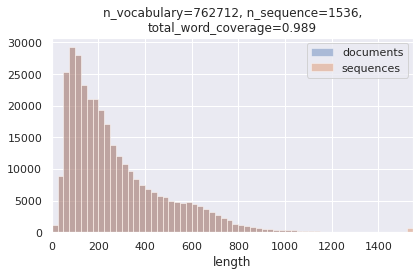

In [10]:
doc_lengths = [len(doc.split()) for doc in docs]

sns.distplot(doc_lengths,
             bins=np.arange(0, 2500, 25),
             kde=False,
             label="documents")
sns.distplot(sequence_lengths,
             bins=np.arange(0, 2500, 25),
             kde=False,
             label="sequences")
total_word_coverage = np.round(np.sum(sequence_lengths) / np.sum(doc_lengths), 3)
plt.title(f"n_vocabulary={n_vocabulary}, n_sequence={n_sequence},\n"
          f"total_word_coverage={total_word_coverage}")
plt.xlim(0, 1550)
plt.xlabel("length")
plt.legend()
plt.tight_layout()
plt.show()

## Word embeddings

In [11]:
n_embedding = 300 # 300 required by pretrained embeddings

### FastText

In [12]:
reset_seed()

ft_path = f"data/fasttext_{version}.model"
# ft_path = f"train/fasttext_{version}.model"

try:
    ft = FastText.load(ft_path)
except:
    ft = FastText(sentences=[doc.split() for doc in docs], size=n_embedding,
                  min_count=1, workers=cpu_count(), seed=seed)
    ft.save(ft_path)

print(len(list(ft.wv.vocab)))
print(ft.wv.index2entity[:100])

762711
['the', '.', ',', 'to', 'of', 'in', '-', 'a', 'and', '"', 'said', 'on', ')', '(', "'s", 'for', 'The', 'at', 'was', '$', 'that', 'is', 'by', 'with', 'from', 'percent', 'it', 'be', '/', 'as', 'million', 'its', 'will', 'has', '--', 'were', 'not', '*', 'would', 'year', 'are', 'have', 'an', 'he', 'which', ':', 'had', 'market', 'up', 'A', 'but', 'after', 'this', 'N', 'company', 'one', 'U.S.', 'been', 'billion', 'also', 'government', 'last', 'or', '1997', 'two', 'their', 'they', 'first', 'over', 'new', '1', 'his', 'more', 'June', 'shares', 'about', 'week', 'It', 'than', 'Bank', 'I', 'share', 'who', 'Tuesday', '1996', '%', 'per', 'Wednesday', 'May', 'we', 'Thursday', 'expected', 'July', 'Monday', 'We', 'some', 'Friday', 'down', 'could', 'three']


### Word2Vec

In [13]:
reset_seed()

w2v_path = f"data/w2v_{version}.model"
# w2v_path = f"train/w2v_{version}.model"

try:
    w2v = Word2Vec.load(w2v_path)
except:
    w2v = Word2Vec(sentences=[doc.split() for doc in docs], size=n_embedding,
                   min_count=1, workers=cpu_count(), seed=seed)
    w2v.save(w2v_path)

print(len(list(w2v.wv.vocab)))
print(w2v.wv.index2entity[:100])

762711
['the', '.', ',', 'to', 'of', 'in', '-', 'a', 'and', '"', 'said', 'on', ')', '(', "'s", 'for', 'The', 'at', 'was', '$', 'that', 'is', 'by', 'with', 'from', 'percent', 'it', 'be', '/', 'as', 'million', 'its', 'will', 'has', '--', 'were', 'not', '*', 'would', 'year', 'are', 'have', 'an', 'he', 'which', ':', 'had', 'market', 'up', 'A', 'but', 'after', 'this', 'N', 'company', 'one', 'U.S.', 'been', 'billion', 'also', 'government', 'last', 'or', '1997', 'two', 'their', 'they', 'first', 'over', 'new', '1', 'his', 'more', 'June', 'shares', 'about', 'week', 'It', 'than', 'Bank', 'I', 'share', 'who', 'Tuesday', '1996', '%', 'per', 'Wednesday', 'May', 'we', 'Thursday', 'expected', 'July', 'Monday', 'We', 'some', 'Friday', 'down', 'could', 'three']


### Pre-trained FastText

In [14]:
def load_embeddings(fname, skip_first):
    embedding_idx = {}
    with open(fname, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f):
            if i == 0 and skip_first:
                continue
            vals = line.rstrip().split()
            token = "".join(vals[:-300])
            embedding = np.array(vals[-300:], dtype=np.float32)
            embedding_idx[token] = embedding
    return embedding_idx

In [15]:
ft_pretrained = load_embeddings("data/crawl-300d-2M.vec", skip_first=True)

token_iter = iter(ft_pretrained)
print([next(token_iter) for i in range(100)])

[',', 'the', '.', 'and', 'to', 'of', 'a', 'in', 'is', 'for', 'that', 'I', 'it', 'on', 'with', ')', ':', '"', '(', 'The', 'you', 'was', 'are', 'or', 'this', 'as', 'have', 'at', 'from', '!', "'s", 'but', 'by', 'not', '?', 'your', 'all', '/', 'be', 'we', 'my', 'one', '-', 'will', 'they', 'so', 'which', '”', '“', 'has', '...', 'just', 'he', 'their', 'can', 'about', 'his', 'our', ';', 'when', 'more', 'had', 'do', 'some', 'time', 'like', 'also', 'there', 'them', 'get', 'what', 'out', "'", 'me', 'her', 'an', 'were', 'This', 'It', 'up', 'would', 'if', 'who', 'new', 'only', 'A', '–', 'people', 'any', 'We', 'make', 'other', 'In', 'then', 'its', 'use', 'said', 'now', 'no', 'first']


### Pre-trained GloVe

In [16]:
if version == "tokenized_cased":
    glove_pretrained = load_embeddings("data/glove.840B.300d.txt", skip_first=False)
else:
    glove_pretrained = load_embeddings("data/glove.42B.300d.txt", skip_first=False)
    
token_iter = iter(glove_pretrained)
print([next(token_iter) for i in range(100)])

[',', '.', 'the', 'and', 'to', 'of', 'a', 'in', '"', ':', 'is', 'for', 'I', ')', '(', 'that', '-', 'on', 'you', 'with', "'s", 'it', 'The', 'are', 'by', 'at', 'be', 'this', 'as', 'from', 'was', 'have', 'or', '...', 'your', 'not', '!', '?', 'will', 'an', "n't", 'can', 'but', 'all', 'my', 'has', '|', 'do', 'we', 'they', 'more', 'one', 'about', 'he', ';', "'", 'out', '$', 'their', 'so', 'his', 'up', 'It', '&', 'like', '/', '1', 'which', 'if', 'would', 'our', '[', ']', 'me', 'who', 'just', 'This', 'time', 'what', 'A', '2', 'had', 'when', 'there', 'been', 'some', 'get', 'were', 'other', 'also', 'In', 'her', 'them', 'You', 'new', 'We', 'no', 'any', '>', 'people']


### Embedding matrices

In [17]:
def create_embedding_matrix(embedding_model):
    embedding_matrix = np.zeros((n_vocabulary, n_embedding))
    unknown_token_count = 0
    for token, i in word_idx.items():
        if i >= n_vocabulary:
            continue
        if token in embedding_model:
            embedding_matrix[i] = embedding_model[token]
        else:
            unknown_token_count += 1

    print(unknown_token_count)
    print(embedding_matrix.shape)
    print(embedding_matrix[1][:20])

    return embedding_matrix

In [18]:
ft_embedding_matrix = create_embedding_matrix(ft)

0
(762712, 300)
[ 2.60082126  4.1615696   3.10287261  4.46255398  0.49275851 -3.08360028
  5.75870943  3.70959353  0.92910308 -0.94961739  0.0122972   5.87578487
  0.45075765 -3.08726764 -1.17578566  2.33939171 -0.92189437 -0.80971539
  1.7391876  -2.2687695 ]


In [19]:
w2v_embedding_matrix = create_embedding_matrix(w2v)

0
(762712, 300)
[-0.63477027 -0.77177155 -0.5531857   1.17861974  0.95079625 -0.01210889
 -0.86642587 -0.2856015  -1.40522826  0.75717586 -1.6686604   2.61663437
 -2.13727951 -0.03661137 -1.20471513 -1.72690833  0.86653012  0.21646138
  0.04978285 -0.05401069]


In [20]:
ft_pretrained_embedding_matrix = create_embedding_matrix(ft_pretrained)

499966
(762712, 300)
[ 0.0231      0.017       0.0157     -0.0773      0.1088      0.0031
 -0.1487     -0.26719999 -0.0357     -0.0487      0.0807      0.1532
 -0.0739     -0.0291     -0.0445     -0.0014      0.1014      0.0186
 -0.0253      0.02      ]


In [21]:
glove_pretrained_embedding_matrix = create_embedding_matrix(glove_pretrained)

463359
(762712, 300)
[ 0.27204001 -0.06203    -0.1884      0.023225   -0.018158    0.0067192
 -0.13877     0.17708001  0.17709     2.58820009 -0.35179001 -0.17312001
  0.43285    -0.10708     0.15006    -0.19982    -0.19092999  1.18710005
 -0.16207001 -0.23537999]


## Shuffling the data

In [22]:
n_samples = None
x_train, y_train = shuffle(sequences[:n_train],
                           train_labels,
                           random_state=seed,
                           n_samples=n_samples)
x_test = sequences[n_train:]

## Cross-evaluating the models

In [25]:
def cross_evaluate(model_initializer, batch_size=256, model_params={}):
    model = model_initializer(n_vocabulary, n_embedding, n_sequence, n_labels,
                      **model_params)
    model.summary()
    plot_model(model, to_file=f"model_plots/{model_initializer.__name__}_{version}.png",
               show_shapes=True)

    cv_scores = []
    mskf = MultilabelStratifiedKFold(n_splits=5, random_state=seed)
    for train, val in mskf.split(x_train, y_train):
        model = model_initializer(n_vocabulary, n_embedding, n_sequence, n_labels,
                                  **model_params)
        es = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
        history = model.fit(x_train[train],
                            y_train[train],
                            batch_size=batch_size,
                            epochs=100,
                            verbose=1,
                            validation_data=(x_train[val], y_train[val]),
                            callbacks=[es])

        y_val_pred_prob = model.predict(x_train[val], batch_size=batch_size, verbose=1)
        y_val_pred = np.round(y_val_pred_prob)

        scores = {}
        scores["accuracy"] = accuracy_score(y_train[val], y_val_pred)
        scores["F1 (macro)"] = f1_score(y_train[val], y_val_pred, average="macro")
        scores["F1 (micro)"] = f1_score(y_train[val], y_val_pred, average="micro")
        scores["LRAP"] = label_ranking_average_precision_score(y_train[val],
                                                               y_val_pred_prob)
        scores["NDCG"] = ndcg_score(y_train[val], y_val_pred_prob)
        scores["timestamp"] = round(datetime.timestamp(datetime.now()))
        cv_scores.append(scores)
        print(scores)

        y_test_pred_prob = model.predict(x_test, batch_size=batch_size, verbose=1)
        y_test_pred = np.round(y_test_pred_prob)
        
        np.savetxt(f"test_results/{model_initializer.__name__}_{version}_" +
                   f"{scores['timestamp']}_" +
                   f"{np.round(scores['F1 (micro)'], 6)}.txt", y_test_pred, fmt="%d")

    cv_scores_df = pd.DataFrame(cv_scores)
    display(cv_scores_df)
    print(cv_scores_df.drop("timestamp", axis=1).mean())

In [ ]:
reset_seed()
cross_evaluate(models.bi_lstm_1, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix": ft_pretrained_embedding_matrix})

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1536, 300)         228813600 
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 512)               1140736   
_________________________________________________________________
dense_8 (Dense)              (None, 126)               64638     
Total params: 230,018,974
Trainable params: 1,205,374
Non-trainable params: 228,813,600
_________________________________________________________________
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/

In [35]:
reset_seed()
cross_evaluate(models.cnn_bi_lstm_1, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix": ft_pretrained_embedding_matrix})

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1536, 3

937/937 [==============================] - 116s 124ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 19/100
937/937 [==============================] - 117s 124ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 20/100
937/937 [==============================] - 116s 124ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 21/100
937/937 [==============================] - 117s 125ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 22/100
937/937 [==============================] - 118s 126ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 23/100
937/937 [==============================] - 116s 124ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 24/100
937/937 [==============================] - 116s 124ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 25/100
937/937 [==============================] - 116s 124ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 26/100
937/937 [==============================] - 120s 128ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 00026: early stopping
235/235 [======================

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG,timestamp
0,0.695845,0.581566,0.893320,0.957003,0.974551,1590751403
1,0.695762,0.581680,0.893395,0.956778,0.973658,1590754175
2,0.701056,0.599115,0.895754,0.957419,0.977325,1590757639
3,0.697013,0.596322,0.893927,0.957017,0.974021,1590760751
4,0.698897,0.593937,0.894144,0.957036,0.975568,1590763757


accuracy      0.697715
F1 (macro)    0.590524
F1 (micro)    0.894108
LRAP          0.957051
NDCG          0.975025
dtype: float64


In [ ]:
reset_seed()
cross_evaluate(models.cnn_bi_lstm_1, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "binary_crossentropy",
    "embedding_matrix": ft_pretrained_embedding_matrix})

In [26]:
reset_seed()
cross_evaluate(models.cnn_bi_lstm_2, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix": ft_pretrained_embedding_matrix})

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1536, 300)         228813600 
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1535, 400)         240400    
_________________________________________________________________
batch_normalization_4 (Batch (None, 1535, 400)         1600      
_________________________________________________________________
re_lu_4 (ReLU)               (None, 1535, 400)         0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 767, 400)          0         
_______

937/937 [==============================] - 180s 192ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 13/100
937/937 [==============================] - 179s 191ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 14/100
937/937 [==============================] - 178s 190ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 15/100
937/937 [==============================] - 179s 191ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 16/100
937/937 [==============================] - 178s 190ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 17/100
937/937 [==============================] - 179s 191ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 18/100
937/937 [==============================] - 178s 190ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 19/100
937/937 [==============================] - 178s 189ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 20/100
937/937 [==============================] - 178s 190ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 21/100
937/937 [==============================] - 178

937/937 [==============================] - 178s 189ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 16/100
937/937 [==============================] - 179s 191ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 17/100
937/937 [==============================] - 178s 190ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 18/100
937/937 [==============================] - 178s 189ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 19/100
937/937 [==============================] - 178s 190ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 20/100
937/937 [==============================] - 180s 192ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 21/100
937/937 [==============================] - 177s 189ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 22/100
937/937 [==============================] - 178s 190ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 23/100
937/937 [==============================] - 177s 189ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 24/100
937/937 [==============================] - 178

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG,timestamp
0,0.702717,0.586931,0.894273,0.957220,0.974731,1590771319
1,0.700549,0.577733,0.893922,0.956638,0.973597,1590776235
2,0.705859,0.587825,0.895878,0.956902,0.977095,1590781885
3,0.701967,0.572793,0.894274,0.956899,0.974193,1590786613
4,0.707104,0.585106,0.895013,0.956471,0.975138,1590792276


accuracy      0.703639
F1 (macro)    0.582078
F1 (micro)    0.894672
LRAP          0.956826
NDCG          0.974951
dtype: float64


In [ ]:
reset_seed()
cross_evaluate(models.bi_lstm_1, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix": glove_pretrained_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.cnn_bi_lstm_1, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix": glove_pretrained_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.cnn_bi_lstm_2, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix": glove_pretrained_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.cnn_bi_lstm_1, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix": w2v_embedding_matrix})

In [ ]:
reset_seed()
cross_evaluate(models.split_cnn_bi_lstm_2, model_params={
    "filters_1": 400, "filters_2": 500, "loss": "mean_squared_error",
    "embedding_matrix_1": ft_pretrained_embedding_matrix,
    "embedding_matrix_2": glove_pretrained_embedding_matrix})